# 4th Year Project: Feature Extraction in the Frequency Domain 
`
Last Modified: 17th Mar 2020
Author: Ken Yew Piong, Chin Yang Tan
UCL ID: 16004444
`

### Description:
#### This is a standalone tool to visualise time series, FFT and PSD plots of accelerometer and gyroscope CSV data. </br> It also visualises the statistical trends by level of severity of features extracted in the frequency domain.
```tex
USER GUIDE:
1. Install the required libraries in the 'Library Import' section
2. Copy the directory path to the 'sara-trial-2020' folder provided in Test 10 - Ken_Yew_Feature_Extraction
3. Change the working_path variable in '2.0 Data Extraction' section to the copied path
4. Click Run All and Enjoy!

USAGE: 
Visualisation of time series, FFT and PSD plots
1. For individual plots, go to section '4.3 Individual Plots'
2. For multiple plots by level of severity, go to section '4.4 Multiple Plots by Level of Severity'

Visualisation of statistical trends
3. For individual statistical plots, go to section '5.1.1 Individual Plots'
4. For multiple statistical plots, go to section '5.1.2 Multiple plots by all statistical features'

REFERENCE: 
1. Go to section '4.2.1 Reference List of Key Names to Plot' and '4.2.2 List of multiple plots'
   for the keywords of what to plot
```

---
## Library Import

In [1]:
import os, math, import_ipynb, mpld3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.fftpack import fft
from scipy import signal

%matplotlib inline
mpld3.enable_notebook()

---
## 1.0 Global Parameters for Plot Customisation

In [2]:
# ========================================================
# Global Configuration Dictionary for Plot Customisation
# ========================================================
# use pylab.rcParams.update(params) to update settings
params = {'lines.linewidth' : 1,
          'legend.fontsize': 24,
          'legend.loc': 'best',
          'figure.figsize': (17, 10),
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize': 24,
         'ytick.labelsize': 24}

# ====================================
# Update plot customisation parameters
# ====================================
pylab.rcParams.update(params)

--- 
## 2.0 Data Extraction

In [3]:
# ========================================================
# 1. Specify the directory path to the dataset of interest
# ========================================================
working_path = '/Users/kenyew/Documents/Git/Parkinson-Disease-Repository/Testground/Test 10 - Ken Yew_Feature_Extraction/sara-trial-2020'
print(working_path)
os.chdir(working_path)

# Dictionary storing the manual truncation timestamps for each CSV file
df_dict = {}
pd_data_dict = {'ftap-lvl0': [14.8, 21.0],
              'ftap-lvl1': [11.0, 20.1],
              'ftap-lvl2': [12.2, 28.5],
              'ftap-lvl3': [13.5, 26.0],
              'ftap-lvl4': [13.4, 27],
              'hmove-lvl0': [10.5, 17.5],
              'hmove-lvl1': [10.2, 18.8],
              'hmove-lvl2': [10.2, 22.2],
              'hmove-lvl3': [11.0, 32.0],
              'hmove-lvl4': [11.0, 42.5],
              'toetap-lvl0': [12.3, 18.6],
              'toetap-lvl1': [10, 17.5],
              'toetap-lvl2': [9, 22.5],
              'toetap-lvl3': [8.5, 25.5],
              'toetap-lvl4': [8.8, 26.0]
}

# ===============================================================================
# 2. Algorithm to automatically apply the truncation timestamps to each CSV file 
#    and store the resulting df in a dictionary database called df_dict
# ===============================================================================
for dirpath, dirnames, filenames in os.walk(os.getcwd()): 
    for filename in filenames: 
        path = os.path.join(dirpath, filename)
        for gesture in list(pd_data_dict.keys()): # go through CSV files that have matching key names from pd_data_dict
            if gesture in filename: 
                df = pd.read_csv(path)
                start1 = pd_data_dict[gesture][0] # beginning timestamp
                end1 = pd_data_dict[gesture][1] # ending timestamp
                df = df[(df['elapsed (s)'] >= start1) & (df['elapsed (s)'] <= end1)] # truncate the data
                if 'Accelerometer' in filename: 
                    df_dict[gesture+'-accel'] = pd.DataFrame(df) # append the key with accel for accelerometer df
                elif 'Gyroscope' in filename:
                    df_dict[gesture+'-gyro'] = pd.DataFrame(df) # append the key with gyro for gyroscope df

/Users/kenyew/Documents/Git/Parkinson-Disease-Repository/Testground/Test 10 - Ken Yew_Feature_Extraction/sara-trial-2020


---
## 3.0 Data Pre-processing

### 3.1 Pre-processing Functions

In [4]:
def process_HPF(df, highcut, fs, order):
    """
    :FUNCTION: Processes raw dataframes extracted from CSV files, applies a high pass filter with
    the specified high cut-off frequency and returns the dataframe with new appended columns 
    consisting of processed high-passed values for each x,y,z axes data
    :df: Pandas dataframe of raw acc or gyro data (data after using pd.read_csv)
    :highcut: Desired higher cut-off frequency 
    :fs: Sampling frequency (50 Hz for MBient sensors)
    :order: Polynomial order of Butterworth filter
    :file: CSV filename being worked on
    :rtype: Processed Pandas dataframe with new filtered x,y,z values
    """
    processed_df = df.copy() # copies the dataframe leaving the original df intact
    select_cols = processed_df.columns[-3:] # list of the last three column names of the input df to enumerate later
    col_name = ['filtered x-axis (g)', 'filtered y-axis (g)', 'filtered z-axis (g)'] # names of new processed columns
    
    # Butterworth filter for High-Pass applications
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high', analog=False)
    
    # Apply high-pass filter and store processed data into new appended columns
    for idx, col in enumerate(select_cols):
        processed_df[col_name[idx]] = pd.DataFrame(signal.lfilter(b, a, processed_df.loc[:, col])).values
        
    return processed_df # returns a processed df with new appended columns consisting of processed x,y,z values

def process_FFT(df, fs):
    """
    :FUNCTION: Processes raw dataframes extracted from CSV files, applies a Fast Fourier Transform
    and returns the dataframe with new appended columns consisting of processed FFT values for each x,y,z axes data
    :df: Pandas dataframe of raw acc or gyro data (data after using pd.read_csv)
    :fs: Sampling frequency (50 Hz for MBient sensors)
    :rtype: Processed Pandas dataframe with new FFT x,y,z values
    """
    processed_df = df.copy() # copies the dataframe leaving the original df intact
    select_cols = processed_df.columns[-3:] # list of the last three column names of the input df to enumerate later
    col_name = ['FFT magnitude x-axis', 'FFT magnitude y-axis', 'FFT magnitude z-axis'] # names of new processed columns
    result_df = pd.DataFrame() # instantiate dataframe
    
    # Instantiate matrix for FFT
    lgth, num_signal=df.shape
    fqy = np.zeros([lgth, num_signal])

    # Perform FFT and store processed data into new appended columns
    for idx, col in enumerate(select_cols): 
        result_df['frequency (Hz)'] = np.arange(int(lgth/2))/(int(lgth/2)/(fs/2))
        fqy[:,idx] = np.abs(fft(df.loc[:, col]))
        result_df[col_name[idx]] = pd.Series(fqy[0:int(lgth/2),idx])

    return result_df # returns a processed df with new appended columns consisting of processed x,y,z values

def process_PSD(df, fs):
    """
    :DEPENDANCIES: Requires output from def process_FFT(df, fs)
    :FUNCTION: Processes FFT dataframes, calculates the corresponding Power Spectral Density (PSD) values
    and returns the dataframe with new appended columns consisting of processed PSD values for each x,y,z axes data
    :df: Pandas dataframe of raw acc or gyro data (data after using pd.read_csv)
    :fs: Sampling frequency (50 Hz for MBient sensors)
    :rtype: Processed Pandas dataframe with new FFT x,y,z values
    """
    processed_df = df.copy() # copies the dataframe leaving the original df intact
    select_cols = processed_df.columns[-3:] # list of the last three column names of the input df to enumerate later
    psd_col_name = ['psd x-axis', 'psd y-axis', 'psd z-axis'] # names of new processed columns
    result_df = pd.DataFrame() # instantiate dataframe

    # Perform PSD calculations and store processed data into new appended columns
    for idx, col in enumerate(select_cols):
        f_data, psd_data = signal.welch(processed_df.loc[:, col], fs)
        result_df['frequency (Hz)'] = pd.Series(f_data)
        result_df[psd_col_name[idx]] = pd.Series(psd_data)

    return result_df # returns a processed df with new appended columns consisting of processed x,y,z values

### 3.2 Data Pre-processing and Database Creation

In [5]:
# ====================
# Input Parameters
# ====================
fs = 50 # 50 Hz is the hard-wired sampling frequency of the MBient sensor
highcut = 1 # 1 Hz, removing only the starting DC offset for accelerometer data
order = 5 # polynomial order to the 5th power should have sufficient performance for filter

# ====================
# Data Pre-processing
# ====================
# Process all the raw truncated dataframes using the pre-processing functions above and storing the 
# processed dataframes in dictionaries

# =============================================
# 1. High Pass Filter (stored in: hpf_df_dict)
# =============================================
hpf_df_dict = {} 
for key, value in df_dict.items(): # process all the truncated dataframes from the dictionary database
    if 'accel' in key: # apply HPF to accelerometer data only as DC offsets only occur in accelerometers
        hpf_df_dict[key+'-hpf'] = process_HPF(value, highcut, fs, order) # append '-hpf' to key
    else:
        hpf_df_dict[key+'-hpf'] = value

# =============================================
# 2. FFT without HP Filtering (stored in: raw_fft_df_dict)
# =============================================
raw_fft_df_dict = {}
for key, value in df_dict.items(): # process all the truncated dataframes from the dictionary database
    raw_fft_df_dict[key+'-fft'] = process_FFT(value, fs)

# =============================================
# 3. FFT (stored in: fft_df_dict)
# =============================================
fft_df_dict = {}
for key, value in hpf_df_dict.items(): # process all the truncated dataframes from the dictionary database
    fft_df_dict[key+'-fft'] = process_FFT(value, fs)

# =============================================
# 4. PSD (stored in: psd_df_dict)
# =============================================
psd_df_dict = {}
for key, value in hpf_df_dict.items(): # process all the truncated dataframes from the dictionary database
    psd_df_dict[key+'-psd'] = process_PSD(value, fs)

# =============================================
# Database Creation (all of the processed dataframes above are stored in one unified dictionary called 'database')
# =============================================
all_df_dict = [df_dict, hpf_df_dict, raw_fft_df_dict, fft_df_dict, psd_df_dict]
database = {}
for df in all_df_dict:
    database.update(df)

---
## 4.0 Data Visualization

### 4.1 Visualization Functions

In [6]:
def visualize(data_name, plot_df, savefig):
    """
    :FUNCTION: Dynamically plots any type of dataframe (pre-processed or not) and applies the appropriate axes customisation
    :data_name: Name of the dataframe (e.g.: ftap-lvl0-accel-hpf-fft) which can be obtained from the keys of the database dictionary containing all dataframes
    :plot_df: Any Pandas dataframe
    :savefig: Boolean to toggle whether to save the figure in .png or not
    :rtype: void - plots the graph of the input dataframe
    """
    # =============================================
    # Data extraction for plot
    # =============================================
    # Horizontal axis values required for the plot will always be 'frequency (Hz)'
    x_data = 'frequency (Hz)'
    
    # Pinpointing the required columns to extract the vertical axis values required for the plot
    if 'fft' in data_name:
        col_name = ['FFT magnitude x-axis', 'FFT magnitude y-axis', 'FFT magnitude z-axis']
    elif 'psd' in data_name: 
        col_name = ['psd x-axis', 'psd y-axis', 'psd z-axis']
    else: 
        col_name = plot_df.columns[-3:]
        x_data = 'elapsed (s)'

    # =============================================
    # Plot triaxial data
    # =============================================
    fig, ax = plt.subplots() # Instantiate object tuples for MatplotLib plots
    color_map = ['r', 'g', 'b'] # List of color codes to enumerate to when plotting
    labels = ['x-component', 'y-component', 'z-component'] # List of legend labels to enumerate to when plotting
    
    # Plot all three x, y and z axes in the same graph
    for i in range(3):
        ax.plot(plot_df.loc[:, x_data], plot_df.loc[:, col_name[i]], color_map[i], label=labels[i])

    # =============================================
    # Plot Axes Customisation
    # =============================================
    # x-label names depending on datatype 
    if 'fft' in data_name or 'psd' in data_name:
        ax.set_xlabel('Frequency (Hz)')
    else: 
        ax.set_xlabel('Time (s)')

    # y-label names depending on datatype
    if 'psd' in data_name: 
        ax.set_ylabel('Power Spectral Density (V^2/Hz)')
    elif 'accel' in data_name: 
        ax.set_ylabel('Magnitude (g)')
    elif 'gyro' in data_name:
        ax.set_ylabel('Magnitude (deg/s)')

    # Further plot customisations
    ax.set_title(data_name)
    ax.legend(loc='best')
    ax.grid()

    # =============================================
    # Save Plot
    # =============================================
    # Toggle to save the figure as a .png file
    if savefig == True: 
        fig.savefig(f'{data_name}.png')

---
### 4.2.1 Reference List of Key Names to Plot

In [7]:
print(*list(database.keys()), sep='\n')

hmove-lvl2-accel
hmove-lvl3-gyro
hmove-lvl3-accel
hmove-lvl4-accel
hmove-lvl4-gyro
hmove-lvl1-gyro
hmove-lvl0-accel
hmove-lvl0-gyro
hmove-lvl1-accel
hmove-lvl2-gyro
ftap-lvl3-accel
ftap-lvl4-gyro
ftap-lvl3-gyro
ftap-lvl2-accel
ftap-lvl4-accel
ftap-lvl0-gyro
ftap-lvl1-gyro
ftap-lvl0-accel
ftap-lvl2-gyro
ftap-lvl1-accel
toetap-lvl4-accel
toetap-lvl3-gyro
toetap-lvl1-gyro
toetap-lvl2-accel
toetap-lvl0-gyro
toetap-lvl1-accel
toetap-lvl4-gyro
toetap-lvl3-accel
toetap-lvl0-accel
toetap-lvl2-gyro
hmove-lvl2-accel-hpf
hmove-lvl3-gyro-hpf
hmove-lvl3-accel-hpf
hmove-lvl4-accel-hpf
hmove-lvl4-gyro-hpf
hmove-lvl1-gyro-hpf
hmove-lvl0-accel-hpf
hmove-lvl0-gyro-hpf
hmove-lvl1-accel-hpf
hmove-lvl2-gyro-hpf
ftap-lvl3-accel-hpf
ftap-lvl4-gyro-hpf
ftap-lvl3-gyro-hpf
ftap-lvl2-accel-hpf
ftap-lvl4-accel-hpf
ftap-lvl0-gyro-hpf
ftap-lvl1-gyro-hpf
ftap-lvl0-accel-hpf
ftap-lvl2-gyro-hpf
ftap-lvl1-accel-hpf
toetap-lvl4-accel-hpf
toetap-lvl3-gyro-hpf
toetap-lvl1-gyro-hpf
toetap-lvl2-accel-hpf
toetap-lvl0-gyro-hp

### 4.2.2 Lists for multiple plots

In [8]:
ftap_accel_fft_lst = ['ftap-lvl0-accel-hpf-fft', 'ftap-lvl1-accel-hpf-fft','ftap-lvl2-accel-hpf-fft', 'ftap-lvl3-accel-hpf-fft', 'ftap-lvl4-accel-hpf-fft']
hmove_accel_fft_lst = ['hmove-lvl0-accel-hpf-fft', 'hmove-lvl1-accel-hpf-fft','hmove-lvl2-accel-hpf-fft', 'hmove-lvl3-accel-hpf-fft', 'hmove-lvl4-accel-hpf-fft']
toetap_accel_fft_lst = ['toetap-lvl0-accel-hpf-fft', 'toetap-lvl1-accel-hpf-fft','toetap-lvl2-accel-hpf-fft', 'toetap-lvl3-accel-hpf-fft', 'toetap-lvl4-accel-hpf-fft']

ftap_gyro_fft_lst = ['ftap-lvl0-gyro-hpf-fft', 'ftap-lvl1-gyro-hpf-fft','ftap-lvl2-gyro-hpf-fft', 'ftap-lvl3-gyro-hpf-fft', 'ftap-lvl4-gyro-hpf-fft']
hmove_gyro_fft_lst = ['hmove-lvl0-gyro-hpf-fft', 'hmove-lvl1-gyro-hpf-fft','hmove-lvl2-gyro-hpf-fft', 'hmove-lvl3-gyro-hpf-fft', 'hmove-lvl4-gyro-hpf-fft']
toetap_gyro_fft_lst = ['toetap-lvl0-gyro-hpf-fft', 'toetap-lvl1-gyro-hpf-fft','toetap-lvl2-gyro-hpf-fft', 'toetap-lvl3-gyro-hpf-fft', 'toetap-lvl4-gyro-hpf-fft']

ftap_accel_psd_lst = ['ftap-lvl0-accel-hpf-psd', 'ftap-lvl1-accel-hpf-psd','ftap-lvl2-accel-hpf-psd', 'ftap-lvl3-accel-hpf-psd', 'ftap-lvl4-accel-hpf-psd']
hmove_accel_psd_lst = ['hmove-lvl0-accel-hpf-psd', 'hmove-lvl1-accel-hpf-psd','hmove-lvl2-accel-hpf-psd', 'hmove-lvl3-accel-hpf-psd', 'hmove-lvl4-accel-hpf-psd']
toetap_accel_psd_lst = ['toetap-lvl0-accel-hpf-psd', 'toetap-lvl1-accel-hpf-psd','toetap-lvl2-accel-hpf-psd', 'toetap-lvl3-accel-hpf-psd', 'toetap-lvl4-accel-hpf-psd']

ftap_gyro_psd_lst = ['ftap-lvl0-gyro-hpf-psd', 'ftap-lvl1-gyro-hpf-psd','ftap-lvl2-gyro-hpf-psd', 'ftap-lvl3-gyro-hpf-psd', 'ftap-lvl4-gyro-hpf-psd']
hmove_gyro_psd_lst = ['hmove-lvl0-gyro-hpf-psd', 'hmove-lvl1-gyro-hpf-psd','hmove-lvl2-gyro-hpf-psd', 'hmove-lvl3-gyro-hpf-psd', 'hmove-lvl4-gyro-hpf-psd']
toetap_gyro_psd_lst = ['toetap-lvl0-gyro-hpf-psd', 'toetap-lvl1-gyro-hpf-psd','toetap-lvl2-gyro-hpf-psd', 'toetap-lvl3-gyro-hpf-psd', 'toetap-lvl4-gyro-hpf-psd']

all_df_dict = [df_dict, hpf_df_dict, raw_fft_df_dict, fft_df_dict, psd_df_dict]
all_df_lst = [ftap_accel_fft_lst, hmove_accel_fft_lst, toetap_accel_fft_lst, ftap_gyro_fft_lst, hmove_gyro_fft_lst, toetap_gyro_fft_lst, ftap_accel_psd_lst, hmove_accel_psd_lst, toetap_accel_psd_lst, ftap_gyro_psd_lst, 
              hmove_gyro_psd_lst, toetap_gyro_psd_lst]

---
### 4.3 Individual Plots

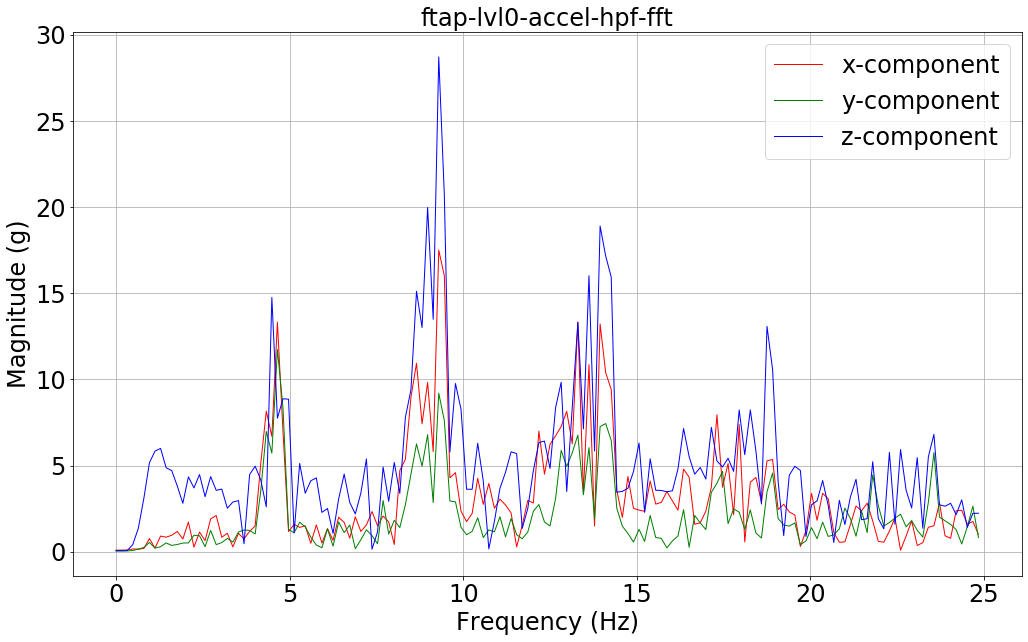

In [9]:
# ====================
# Input Parameters
# ====================
data_name = 'ftap-lvl0-accel-hpf-fft' # Refer to 4.2 Reference List of Key Names to Plot for options to plot individually
savefig = False

plot_df = database[data_name]
visualize(data_name, plot_df, savefig)

---
### 4.4 Multiple Plots by Level of Severity

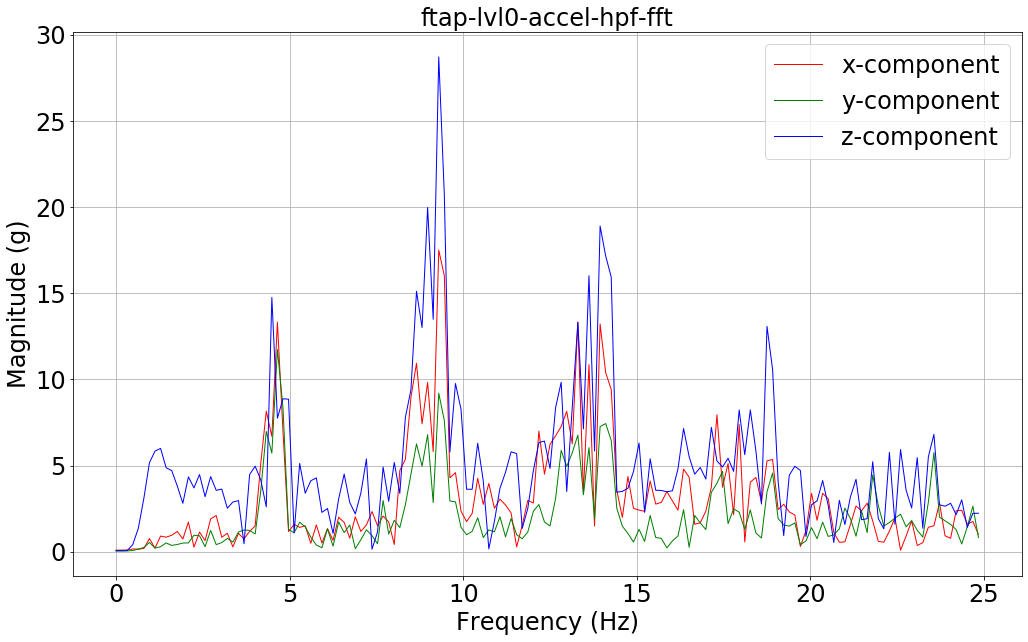

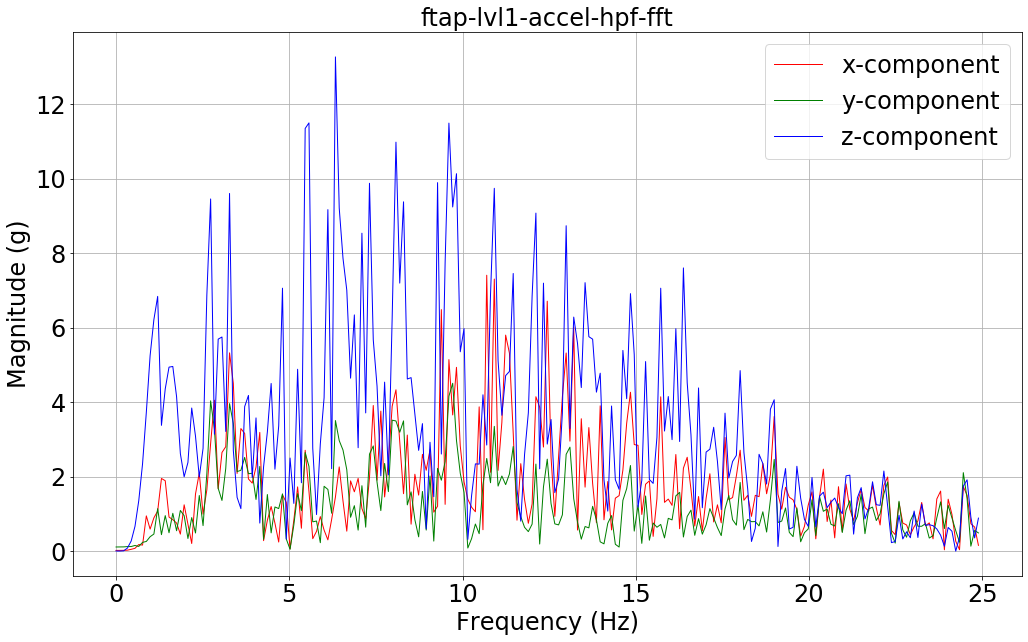

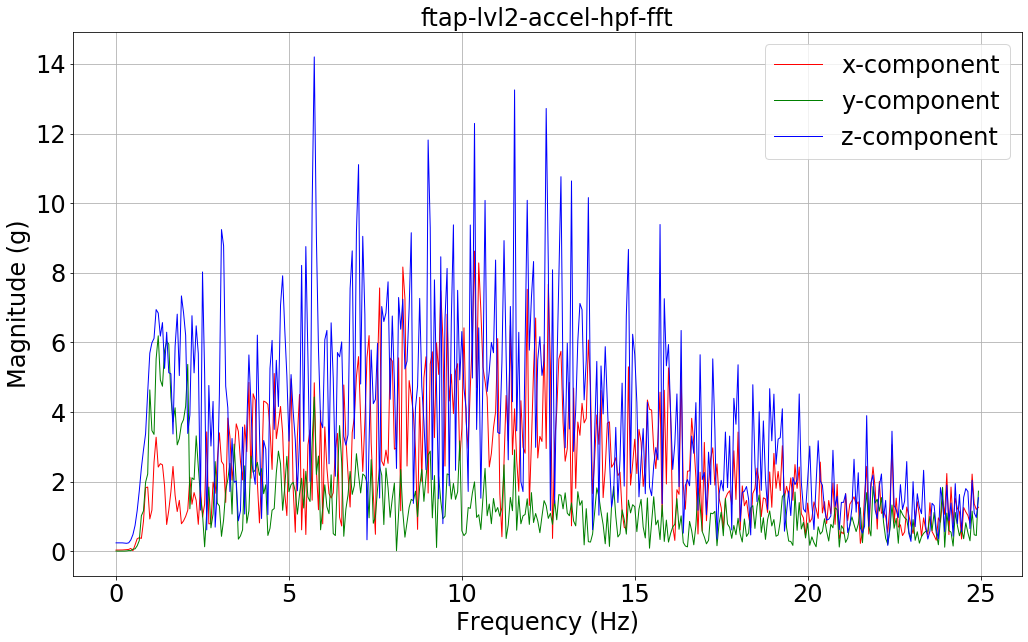

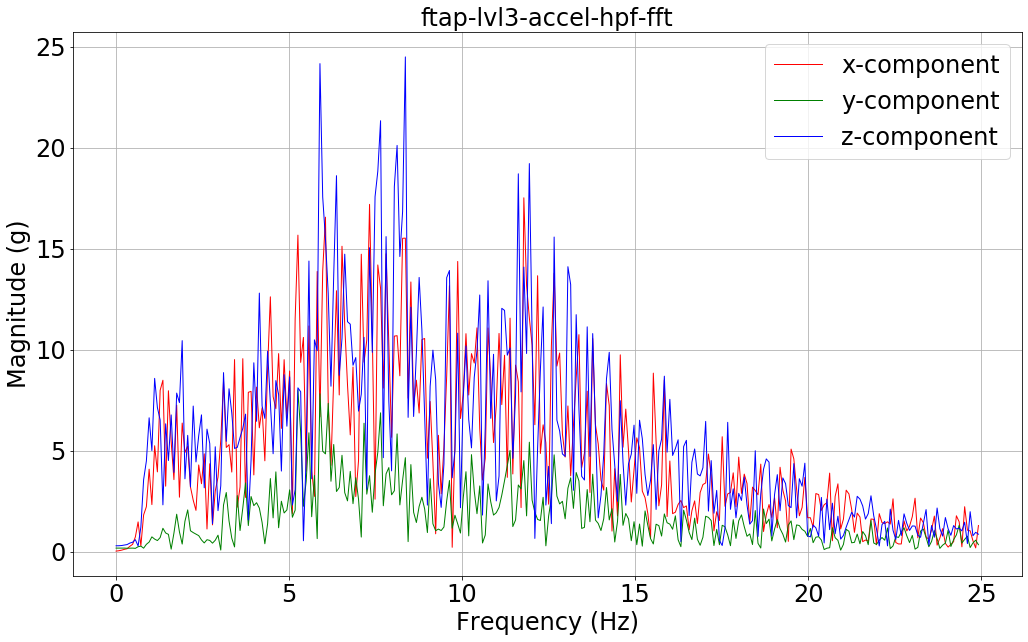

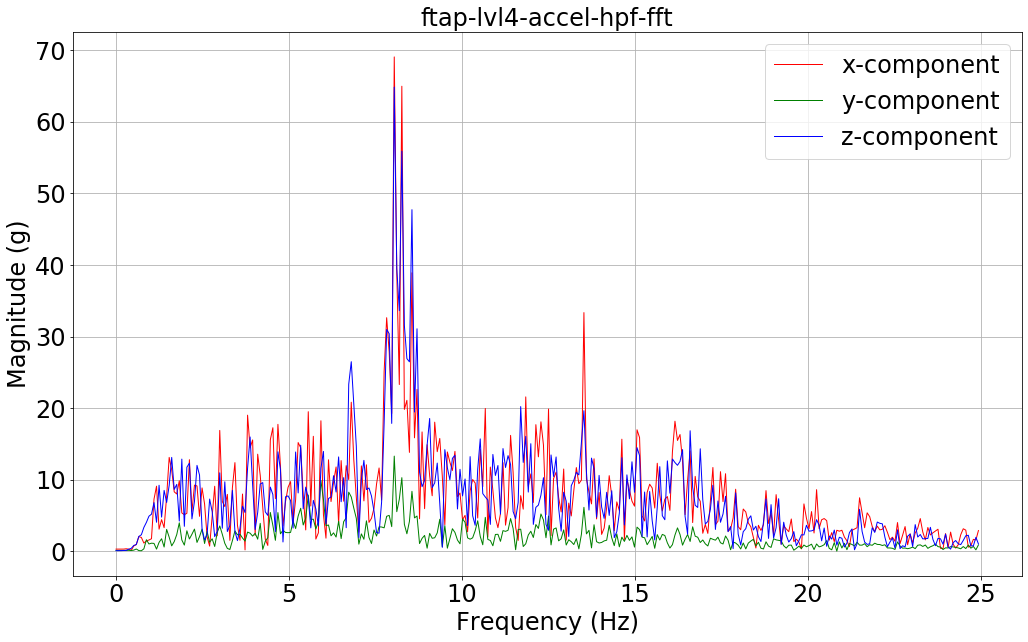

In [10]:
# ====================
# Input Parameters
# ====================
data_name_lst = ftap_accel_fft_lst # Refer to 4.2 Lists of Multiple Plots for options of multiple plots
savefig = False 

for data_name in data_name_lst:
    plot_df = database[data_name]
    visualize(data_name, plot_df, savefig)

---
## 5.0 Feature Extraction in the Frequency Domain
```python 
1. mean and standard deviation of magnitudes of frequency domain
2. 1st quartile, median, 3rd quartile of magnitudes of frequency domain
3. min/max values of magnitudes of frequency domain
4. count of magnitudes of frequencu domain
```

---
### 5.1 Statistical Trends of FFT DF

In [11]:
def process_stats(df, stats_type, lst):
    """
    :DEPENDANCIES: Requires output from any pre-processing functions (e.g.: process_FFT, process_PSD)
    :FUNCTION: Processes the pre-processed dataframes, extract statistical feature values
    and returns a new dataframe with columns consisting of feature values for each x,y,z axes data
    :df: Pandas dataframe of raw acc or gyro data (data after using pd.read_csv)
    :stats_type: String input of type of statistics to extract (e.g.: ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
    :lst: List of dataframes of all severity level belonging to the same gesture and sensor type
    e.g.: ftap_accel_fft_lst = ['ftap-lvl0-accel-hpf-fft', 'ftap-lvl1-accel-hpf-fft','ftap-lvl2-accel-hpf-fft', 'ftap-lvl3-accel-hpf-fft', 'ftap-lvl4-accel-hpf-fft']
    :rtype: Processed Pandas dataframe with new x,y,z feature values
    """
    stats_df = {'data': [], 'stats_type': stats_type, 'x': [], 'y': [], 'z': []} # Gather all information in a dictionary
    for key in lst:
        processed_df = df[key] # running for loop iterations for each dataframe in 'lst' (e.g.: ['ftap-lvl0-accel-hpf-fft', 'ftap-lvl1-accel-hpf-fft','ftap-lvl2-accel-hpf-fft', 'ftap-lvl3-accel-hpf-fft', 'ftap-lvl4-accel-hpf-fft'])
        # Create columns containing the computed feature values and append to a new dataframe, stats_df
        stats_df['data'].append(key) # list of worked dataframes
        stats_df['x'].append(processed_df.describe().loc[stats_type, processed_df.columns[-3]])
        stats_df['y'].append(processed_df.describe().loc[stats_type, processed_df.columns[-2]])
        stats_df['z'].append(processed_df.describe().loc[stats_type, processed_df.columns[-1]])
    return stats_df

def plot_stats(stats_df, savefig):
    """
    :DEPENDANCIES: Requires the output of def process_stats(df, stats_type, lst)
    :FUNCTION: Plots the statistical trends of stats_df by all 5 level of severity
    :stats_df: Dataframe containing the feature extracted statistics output from def plot_stats
    :savefig: Boolean to toggle whether to save the figure in .png or not
    :rtype: void - plots the statistical trends graph by all 5 level of severity
    """
    # =============================================
    # Plot statistical data
    # =============================================
    fig, ax = plt.subplots() # Instantiate object tuples for MatplotLib plots
    color_map = ['r', 'g', 'b'] # List of color codes to enumerate to when plotting
    labels = ['x-component', 'y-component', 'z-component'] # List of legend labels to enumerate to when plotting

     # Plot all 5 levels of severity in the same graph
    for idx, key in enumerate(list(stats_df.keys())[2:]):
        ax.plot(stats_df[key], '-o', linewidth=2, markersize=10, color=color_map[idx], label=labels[idx])
        for i in range(5):
            ax.text(i, stats_df[key][i], f'({i}, {round(stats_df[key][i], 3)})', fontsize=18) # add coordinate labels for each severity level

    # =============================================
    # Plot Axes Customisation
    # =============================================
    # x-label
    ax.set_xlabel('Level of Parkinson Disease Severity')

    # y-label names depending on datatype
    if 'psd' in stats_df['data'][0]:
        ax.set_ylabel('Power Spectral Density (V^2/Hz)')
    elif 'accel' in stats_df['data'][0]:
        ax.set_ylabel('Magnitude of Frequency Domain (g)')
    elif 'gyro' in stats_df['data'][0]:
        ax.set_ylabel('Magnitude of Frequency Domain (deg/s)')

    # Further plot customisations
    title = stats_df['data'][0]
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_title(f"{title}-{stats_df['stats_type']}")
    ax.legend(loc='best')
    ax.grid()

    # =============================================
    # Save Plot
    # =============================================
    # Toggle to save the figure as a .png file
    if savefig == True: 
        fig.savefig(f"{title}-{stats_df['stats_type']}.png")

---
### 5.1.1 Individual Plots

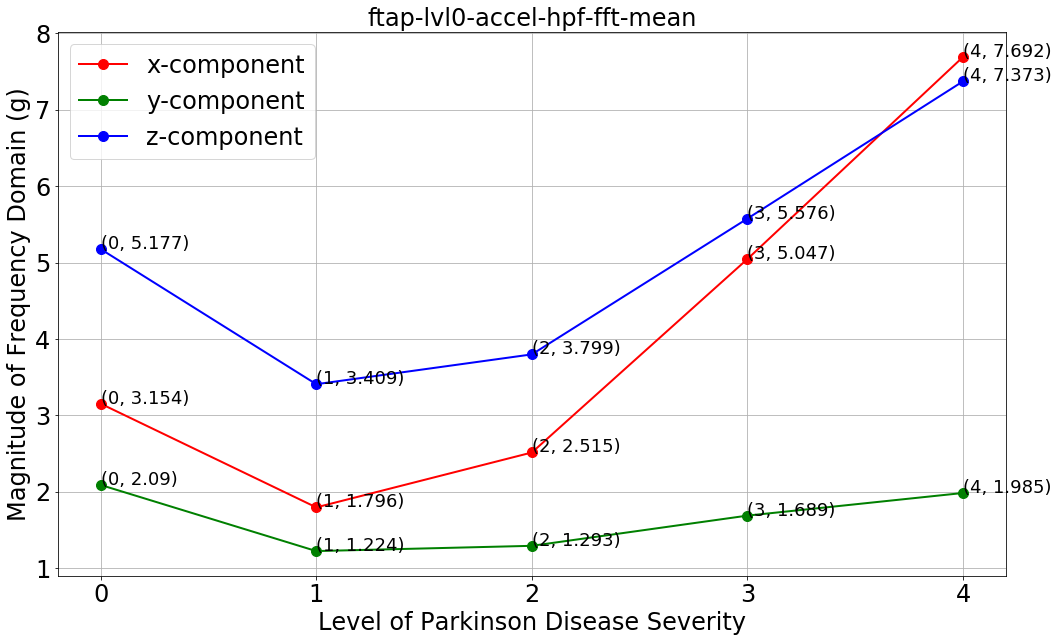

In [12]:
# ====================
# Input Parameters
# ====================
stats_type = 'mean' # options for stats_type are: ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
lst = ftap_accel_fft_lst # Refer to 4.2 Lists of Multiple Plots for options of multiple plots
savefig = False

df = database
stats_df = process_stats(df, stats_type, lst)
plot_stats(stats_df, savefig)

In [13]:
database['ftap-lvl1-accel-hpf-fft'].describe()

,frequency (Hz),FFT magnitude x-axis,FFT magnitude y-axis,FFT magnitude z-axis
count,229.000000,229.000000,229.000000,229.000000
mean,12.445415,1.796436,1.224357,3.408736
std,7.232619,1.401376,0.903914,2.758266
min,0.000000,0.024994,0.055684,0.007117
25%,6.222707,0.817808,0.556787,1.287296
50%,12.445415,1.460673,0.959708,2.654700
75%,18.668122,2.262870,1.663125,4.719470
max,24.890830,7.414925,4.513333,13.277887


In [14]:
database['ftap-lvl0-accel-hpf-fft']

,frequency (Hz),FFT magnitude x-axis,FFT magnitude y-axis,FFT magnitude z-axis
0,0.000000,0.089632,0.038131,0.067271
1,0.160256,0.093185,0.040426,0.064695
2,0.320513,0.102197,0.045415,0.071706
3,0.480769,0.160501,0.072874,0.413422
4,0.641026,0.153313,0.149526,1.359540
...,...,...,...,...
151,24.198718,2.373938,1.280878,2.151025
152,24.358974,2.407984,0.448239,3.013723
153,24.519231,1.599903,1.447570,1.412396
154,24.679487,1.757290,2.646432,2.230744


---
### 5.1.2 Multiple plots by all statistical features

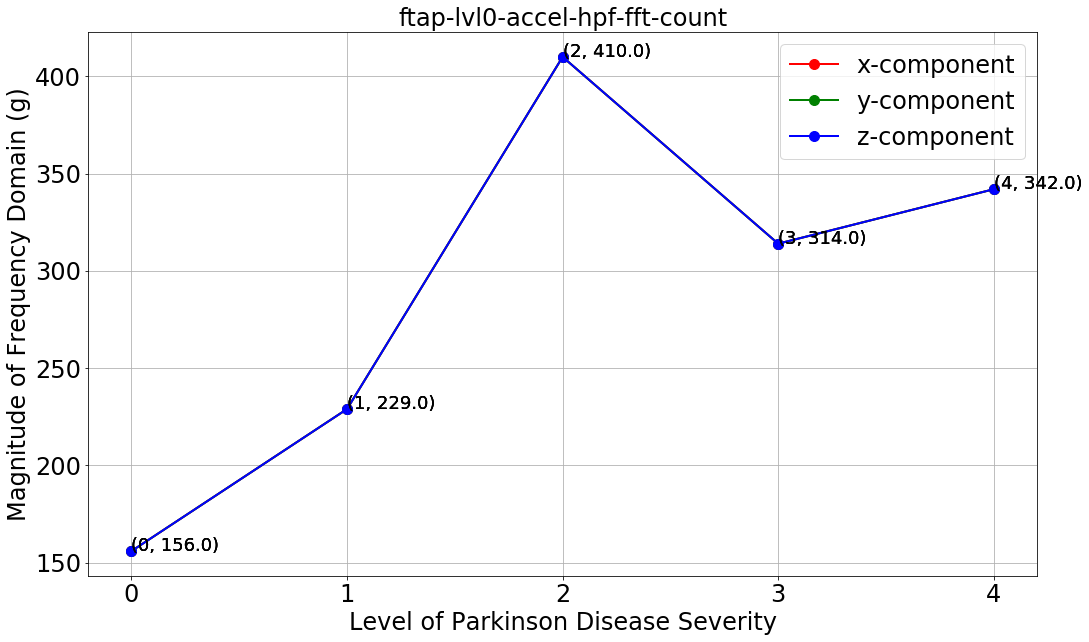

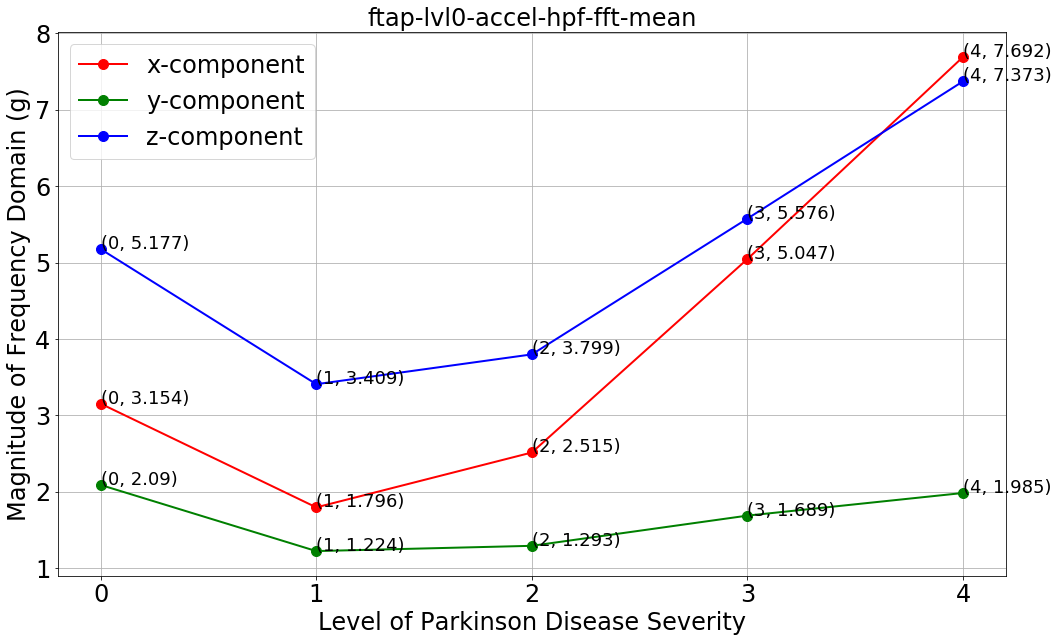

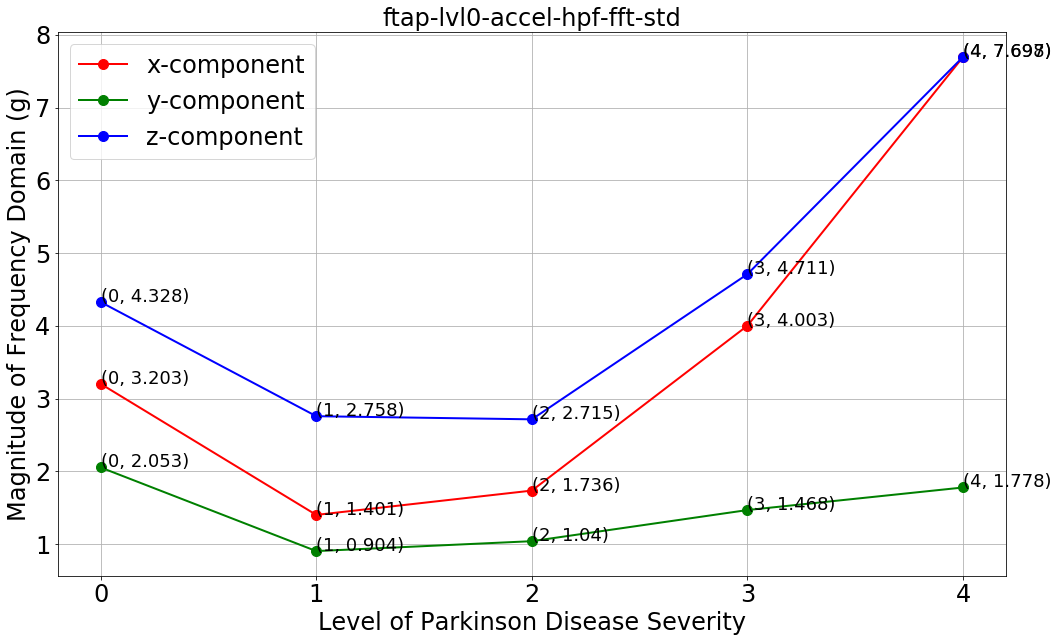

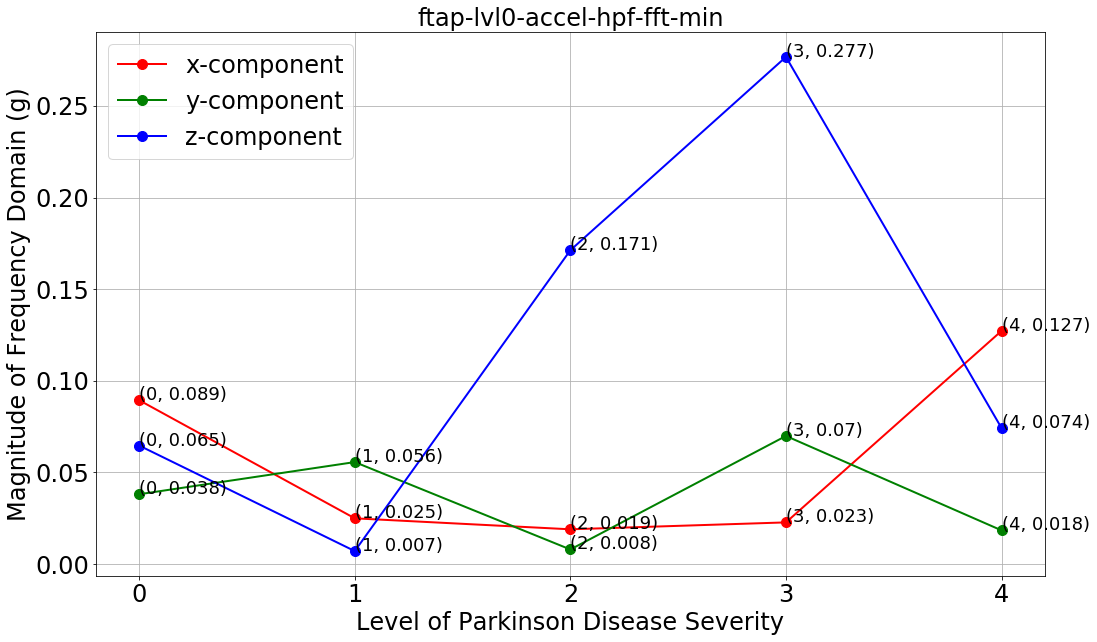

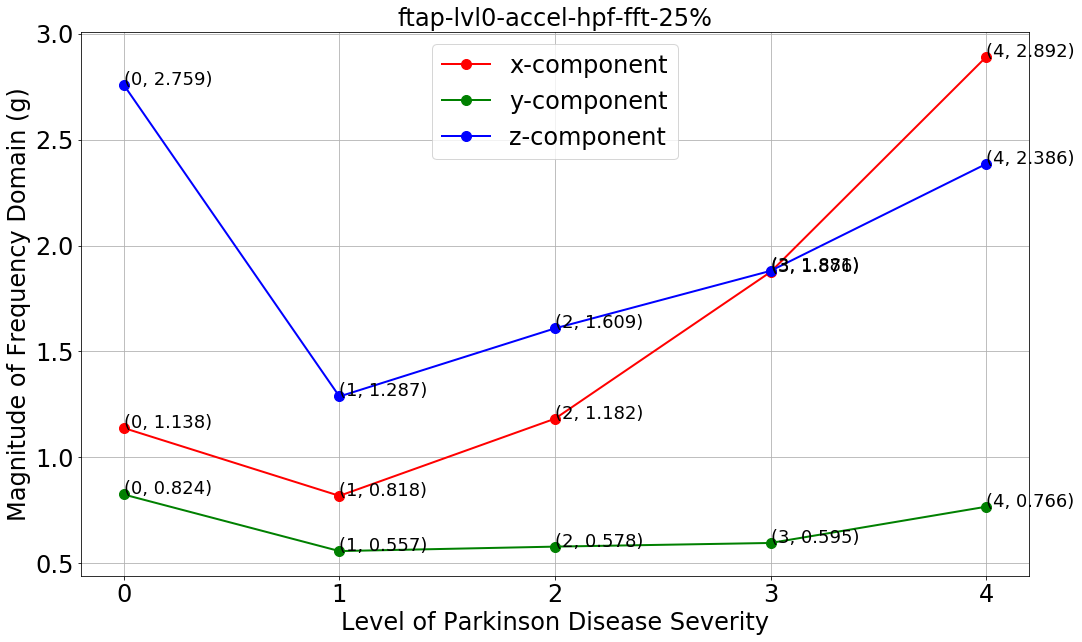

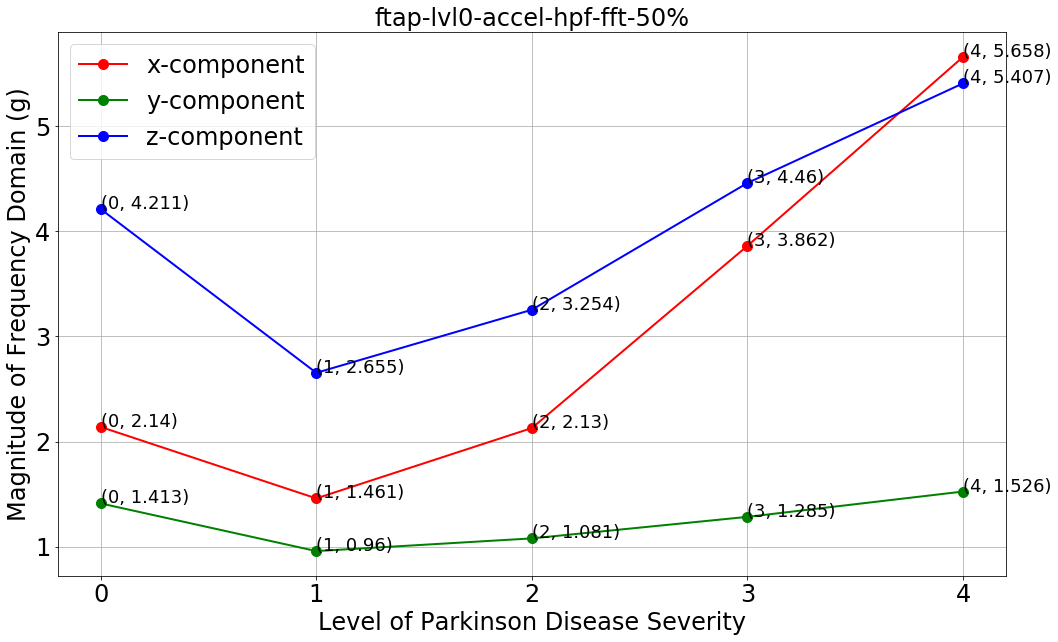

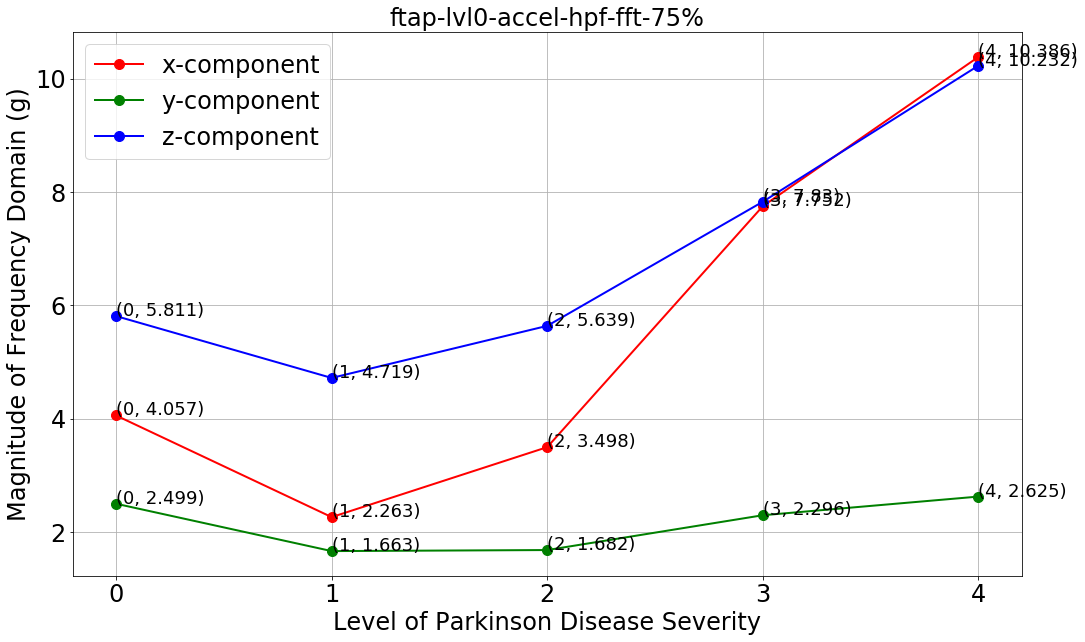

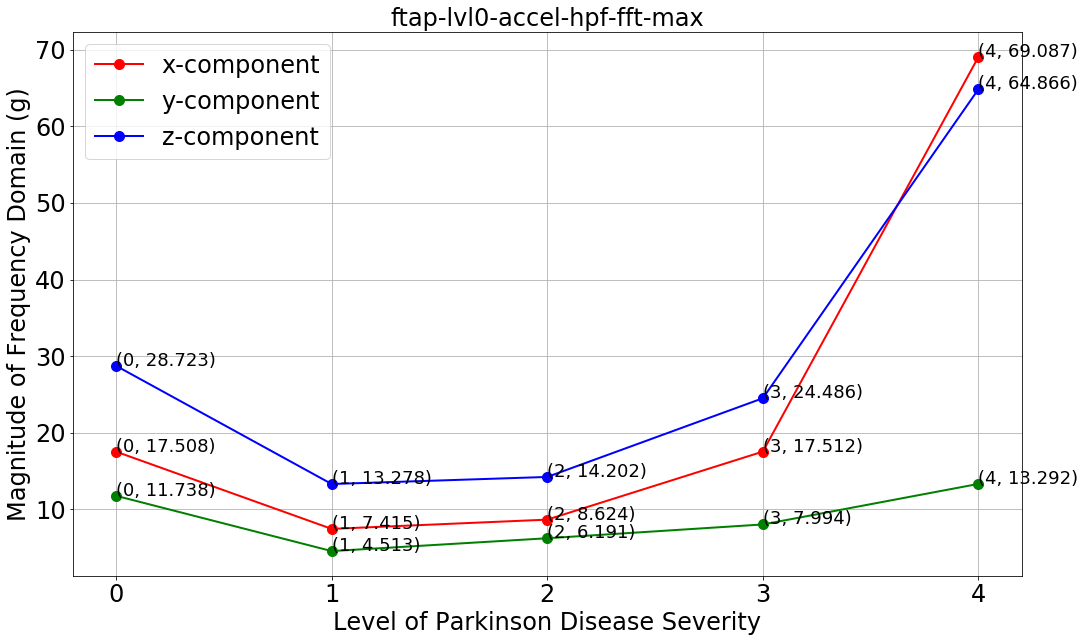

In [15]:
# ====================
# Input Parameters
# ====================
lst = ftap_accel_fft_lst # Refer to 4.2 Lists of Multiple Plots for options of multiple plots
savefig = False

stats_lst = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
df = database
for stats_type in stats_lst: 
    stats_df = process_stats(df, stats_type, lst)
    plot_stats(stats_df, savefig)